# Inference of Gene Regulatory Network using Kinetic Ising Model


In [62]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-08


In [63]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import norm
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

import os
import sys
sys.path.append('../')

import lib.NetAnalysis as na
# from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as figfunc
import lib.funcs_raster as funcs_raster
import lib.funcs_general as funcs_general
import lib.funcs_IsingPars as funcs_Ising
import lib.funcs_ko as funcs_ko

%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial information

In [64]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [65]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Norm Data

In [66]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [67]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## PST + MB

In [68]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [69]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


# Binarization (Half-max)

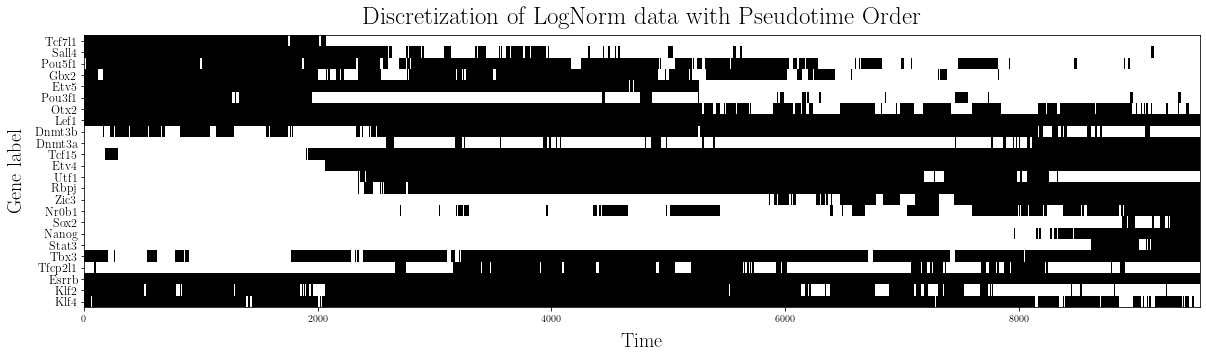

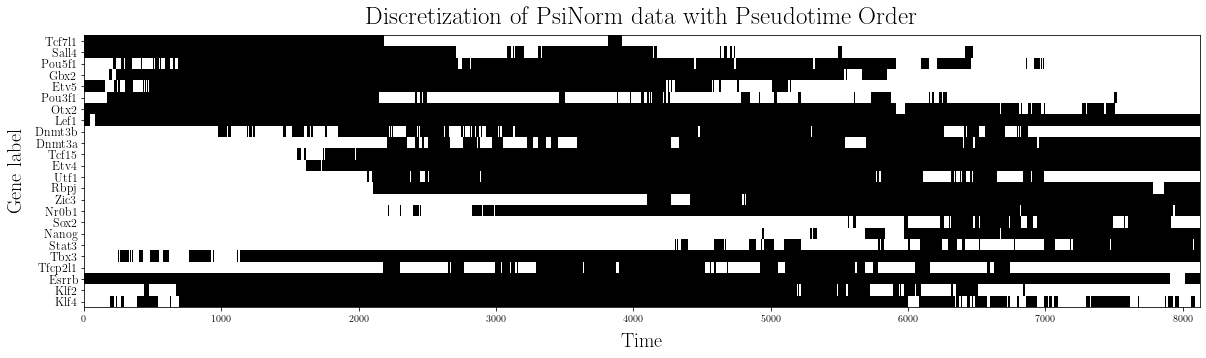

In [70]:
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



# Randomization

In [71]:
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
spins_df_pN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 

print(Ntest)



50


In [72]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [73]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Known Experimentally

## Neighbours interactions

In [74]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [75]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

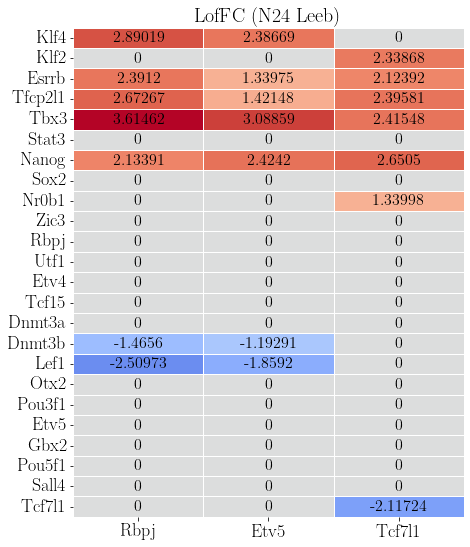

In [76]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0.3)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

# Load Models results

In [77]:
interaction_thr = 0.01


## ISING Info

Threshold = 1% of the maximum

In [78]:
Ntrials = 150

today = "23_02_27" # or other data
data_type = "pst_MB"

# LOADING the data    
lN_arrays = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
lN_matx_sel_true = lN_arrays['array_1']
lN_prec_sel_true = lN_arrays['array_2']
lN_int_val_true = lN_arrays['array_3']

pN_arrays = np.load(path_data+'OUT_ISING/PsiNORM/pN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
pN_matx_sel_true = pN_arrays['array_1']
pN_prec_sel_true = pN_arrays['array_2']
pN_int_val_true =  pN_arrays['array_3']


In [79]:
# load inferred data
lN_high_meanMatx = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_InferredMatrix.npy")
lN_Mean_TP_frac  = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_TPfrac.npy")
lN_Mean_info_int = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_info_ints.npy")

pN_high_meanMatx = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_InferredMatrix.npy")
pN_Mean_TP_frac  = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_TPfrac.npy")
pN_Mean_info_int = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_info_ints.npy")

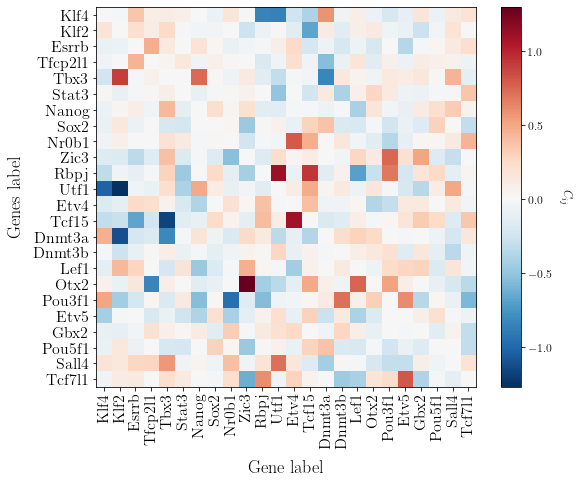

Min and Max values of J:  1.3011 -1.2723


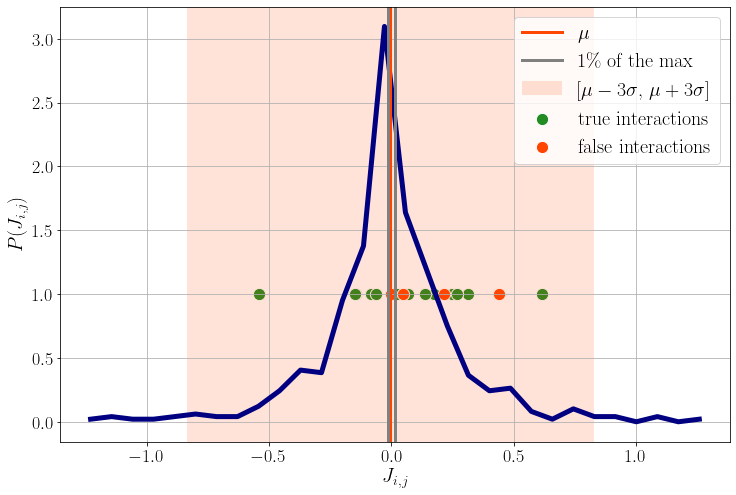

In [80]:
# Matrix of interactions and interactions distribution plots
# all interactions
na.intM_plot(lN_high_meanMatx)
print("Min and Max values of J: ", np.round(lN_high_meanMatx.max(),4), np.round(lN_high_meanMatx.min(),4))

# interactions above the threshold (decoment to see the plot)
# lN_high_meanMatx_thr = na.to_thr_matrix(lN_high_meanMatx, thr=interaction_thr)
# na.intM_plot(lN_high_meanMatx_thr)

# distribution of interactions
na.interactions_plot(lN_high_meanMatx, lN_Mean_info_int, thr = interaction_thr)


# PEARSON's Correlations


In [81]:
# # mini-bulk WITH PST on LogNorm
# cm_lN_mb_pst = np.corrcoef(df_lN_mb_pst)
# np.fill_diagonal(cm_lN_mb_pst, float("Nan")) 
# na.intM_plot(cm_lN_mb_pst)

# # mini-bulk WITH PST on PsiNorm
# cm_pN_mb_pst = np.corrcoef(df_pN_mb_pst)
# np.fill_diagonal(cm_pN_mb_pst, float("Nan"))

# SCODE interactions

# Data generation

In [82]:
params = {"LAMBDA" : [0.01, 0.02, 0.03,0.04, 0.05, 0.07, 0.09],
          "lr"     : [0.8, 0.7, 0.6, 0.5, 0.4, 0.3],
          "drop"   : [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "edrop"  : [15, 20, 25, 30, 35],
          "opt"    : ['MOMENTUM','NADAM'],
          "MOM"    : [0.75, 0.8, 0.85, 0.9, 0.95, 0.99],
          "reg"    : ['L1'],
          "Nepochs": [500, 700, 800, 900, 1200]}


In [83]:
np.random.seed(20961)    #(10101959)#(20091961)
Ntrials = 150

for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
    if ii==31: #31 for PST MB lognorm
        print("\nParams for LogNorm\n", par_sel)
    if ii==147: #31 for PST MB lognorm
        print("\nParams for  PsiNorm\n", par_sel)



Params for LogNorm
 {'LAMBDA': 0.04, 'lr': 0.4, 'drop': 0.85, 'edrop': 15, 'opt': 'MOMENTUM', 'MOM': 0.99, 'reg': 'L1', 'Nepochs': 500}

Params for  PsiNorm
 {'LAMBDA': 0.03, 'lr': 0.6, 'drop': 0.99, 'edrop': 15, 'opt': 'MOMENTUM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 900}


## LogNorm

Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
0 	 0.999895 	 1.0 	 0.4126 	 0.384 	 -0.5504479786551469


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/ml_wrapper.py:34: RuntimeWarning: divide by zero encountered in arctanh
  self.h = np.arctanh(np.mean(x, axis = 1))


100 	 0.339555 	 0.233825 	 0.2829 	 0.0621 	 -4.153041676518795
200 	 0.331083 	 0.301216 	 0.1062 	 0.0478 	 -3.1320863957484186
300 	 0.241861 	 0.190668 	 0.051 	 0.0332 	 -2.6184842870878797
400 	 0.21405 	 0.214354 	 0.0235 	 0.0127 	 -2.351544290862687


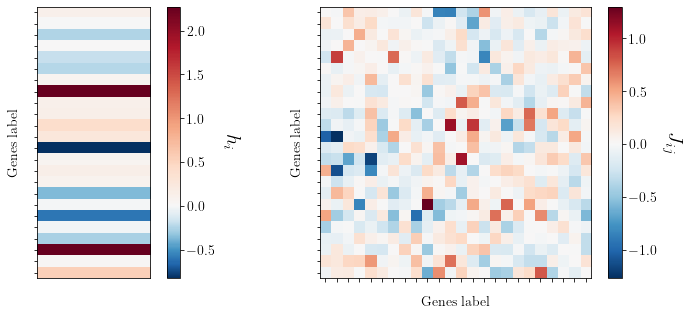


RESULTS for scRNA-seq PST MB with ISING

TP fraction: 0.78

Interaction values:
 [ 0.069  0.175 -0.085 -0.146 -0.542  0.023  0.137  0.312  0.247  0.214
 -0.001  0.048  0.438 -0.063 -0.147 -0.148  0.269  0.614]

TP ints values:
 [ 0.069  0.175 -0.085 -0.146 -0.542  0.023  0.137  0.312  0.247  0.
 -0.     0.     0.    -0.063 -0.147 -0.148  0.269  0.614]


In [84]:
# initialize the reconstruction
Nepochs = 500
LAMBDA = 0.04
lr = 0.4
drop = 0.85
edrop = 15


model_lN_best = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = LAMBDA, opt = 'MOMENTUM', MOM=0.99, reg = 'L1')

# reconstruct the model 
np.random.seed(1234)
model_lN_best.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

# compute the TP fraction and the info of the inferred interactions
lN_rec_tp_val, lN_rec_info_int, lN_rec_matx = funcs_general.TP_plot(TPtrial_list, model_lN_best.J, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type="scRNA-seq PST MB with ISING",
                                                   figplot=False, verbose=True, nbin=30, Norm=True)


### Generating Data

(24, 9547, 100)


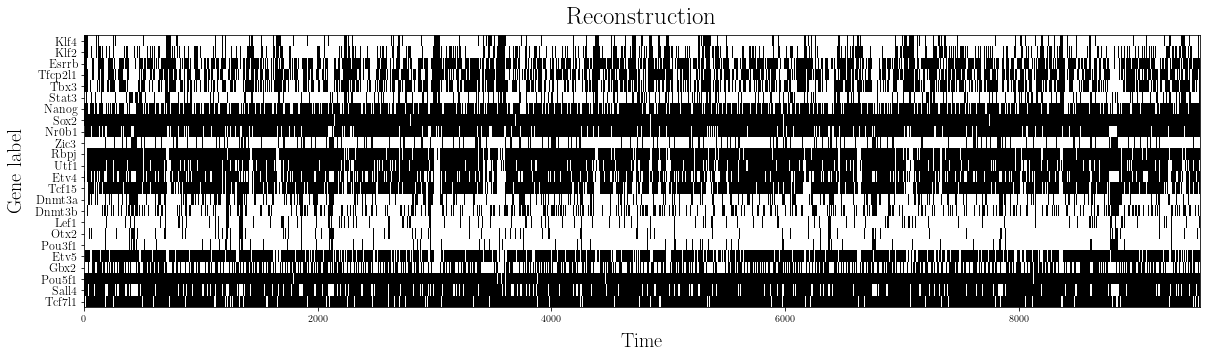

In [85]:
Ntrials=100
spins_new_lN = np.zeros((df_lN_mb_pst.shape[0], df_lN_mb_pst.shape[1], Ntrials))

for ii in range(Ntrials):
    np.random.seed(1234)
    spins_new_lN[:,:,ii] = model_lN_best.generate_samples(seed=ii*2)
    
print(spins_new_lN.shape)

    
fun_plotting.raster_plot(spins_new_lN[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()


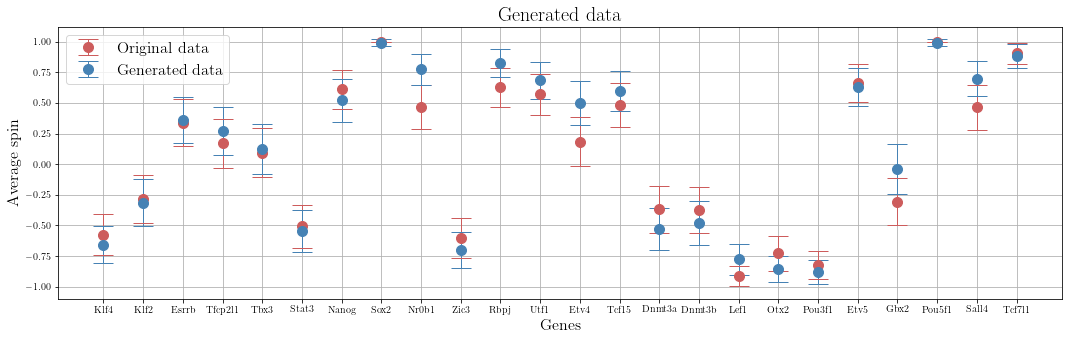

In [86]:
# plot the average activity of the genes  
fig, ax = plt.subplots(1,1, figsize=(18,5))
avg_activity_lN, avg_activity_std_lN         = funcs_ko.plot_activity(spins_df_lN_mb_pst, genes_order, "Original data", "indianred", ax)
avg_activity_lN_sim, avg_activity_std_lN_sim = funcs_ko.plot_activity_simulated(spins_new_lN, genes_order, "Generated data", "steelblue", ax)


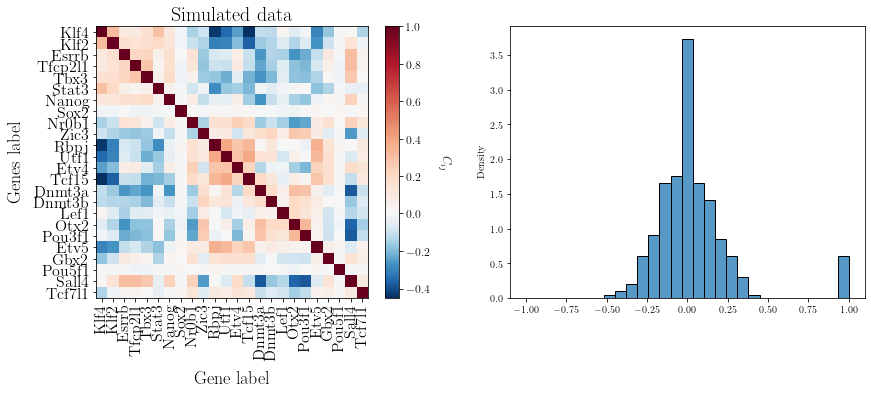

[]


In [87]:
cm_sim_lN = np.zeros((spins_new_lN.shape[0], spins_new_lN.shape[0], spins_new_lN.shape[2]))
for ii in range(spins_new_lN.shape[2]):
    cm_sim_lN[:,:, ii] = np.corrcoef(spins_new_lN[:,:,ii])
cm_sim_lN_mean = np.mean(cm_sim_lN, axis=2)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_lN_mean, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_lN_mean), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_lN_sim = np.where(np.isnan(cm_sim_lN_mean).all(axis=1))[0]
col_nan_lN_sim = np.where(np.isnan(cm_sim_lN_mean).all(axis=0))[0]
# find union of the two arrays
idx_nan_lN_sim = np.union1d(row_nan_lN_sim, col_nan_lN_sim)
print(idx_nan_lN_sim)

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


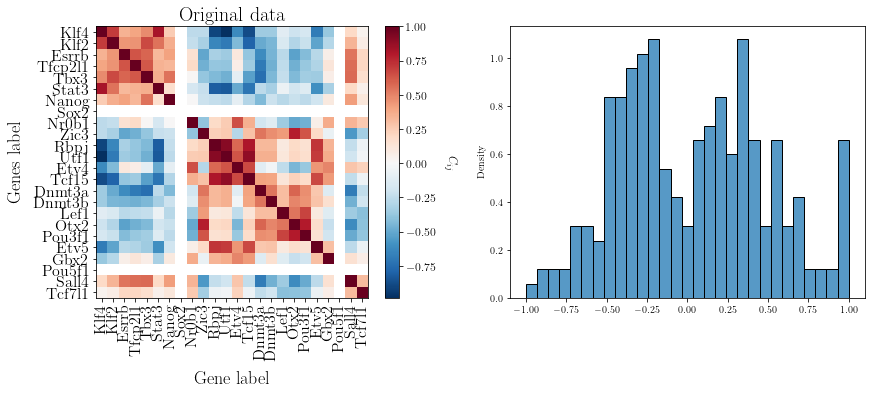

[ 7 21]


(50, 24, 24)

In [88]:
cm_original_lN = np.corrcoef(spins_df_lN_mb_pst)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_original_lN, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_original_lN), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_lN = np.where(np.isnan(cm_original_lN).all(axis=1))[0]
col_nan_lN = np.where(np.isnan(cm_original_lN).all(axis=0))[0]
# find union of the two arrays
idx_nan_lN = np.union1d(row_nan_lN, col_nan_lN)
print(idx_nan_lN)

# unify the list of indices of simulated and original matxs
idx_nan_lN = np.union1d(idx_nan_lN, idx_nan_lN_sim)


# random correlation matrix: shuffle the rows and columns of the original matrix Ntrials times
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])
corr_matxs_rnd_lN.shape

In [89]:
cm_orig_lN_red = cm_original_lN.copy()
cm_sim_lN_red = cm_sim_lN.copy()
corr_matx_rnd_lN_red = corr_matxs_rnd_lN.copy() 
idx_nan_lN_run = idx_nan_lN.copy()
for ii in range(len(idx_nan_lN_run)):
    # remove the rows and columns that contains all nan
    if ii>0: # update the index of the rows and columns to be removed
        idx_nan_lN_run[ii]=idx_nan_lN_run[ii]-1
    # original data
    cm_orig_lN_red = np.delete(cm_orig_lN_red, idx_nan_lN_run[ii], axis=0)
    cm_orig_lN_red = np.delete(cm_orig_lN_red, idx_nan_lN_run[ii], axis=1)   
    #original data randomized (the shuffle is done Ntrials times)    
    corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, idx_nan_lN_run[ii], axis=1)
    corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, idx_nan_lN_run[ii], axis=2)
    # simulated data
    cm_sim_lN_red = np.delete(cm_sim_lN_red, idx_nan_lN_run[ii], axis=0)
    cm_sim_lN_red = np.delete(cm_sim_lN_red, idx_nan_lN_run[ii], axis=1)   
    
genes_selected = np.delete(genes_order, idx_nan_lN)
print("deleted: ", genes_order[idx_nan_lN])

# check if there are nans
if len(np.argwhere(np.isnan(cm_orig_lN_red))):
    print("there are nans in cm_orig_lN_red")


deleted:  ['Sox2' 'Pou5f1']


In [90]:
corr_matxs_rnd_lN.shape

(50, 24, 24)

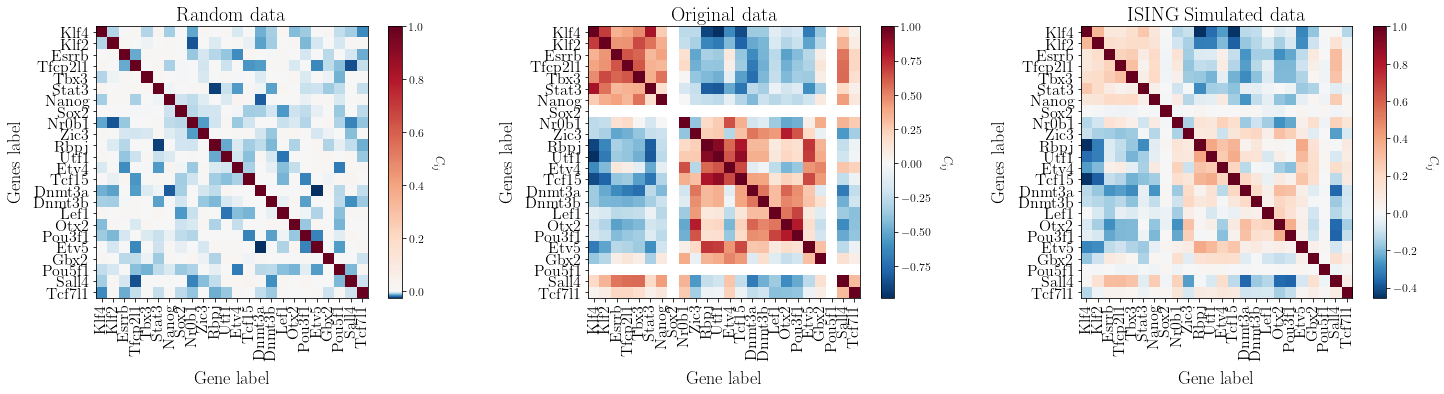

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
figfunc.plotmat(corr_matxs_rnd_lN[0,:,:], fig, ax[0], genes_order, "Random data", )
figfunc.plotmat(cm_original_lN, fig, ax[1], genes_order, "Original data")
figfunc.plotmat(cm_sim_lN[:,:,0], fig, ax[2], genes_order, "ISING Simulated data")
plt.show()



In [92]:
# compute the noise for the distance between matrixes
noise_dist = [funcs_ko.sum_squared_abs_diff(cm_orig_lN_red, corr_matx_rnd_lN_red[i,:,:]) for i in range(50)]
noise_dist = np.mean(noise_dist)
# print(noise_dist)

# compute the  weighted distance between the original and simulated matrixes
result_IO = [funcs_ko.sum_squared_abs_diff(cm_orig_lN_red, cm_sim_lN_red[:,:,i]) for i in range(Ntrials)]
result_IO = np.mean(result_IO)/ noise_dist
print(result_IO)       



0.626537386527725


### Clustering on Simulated Data

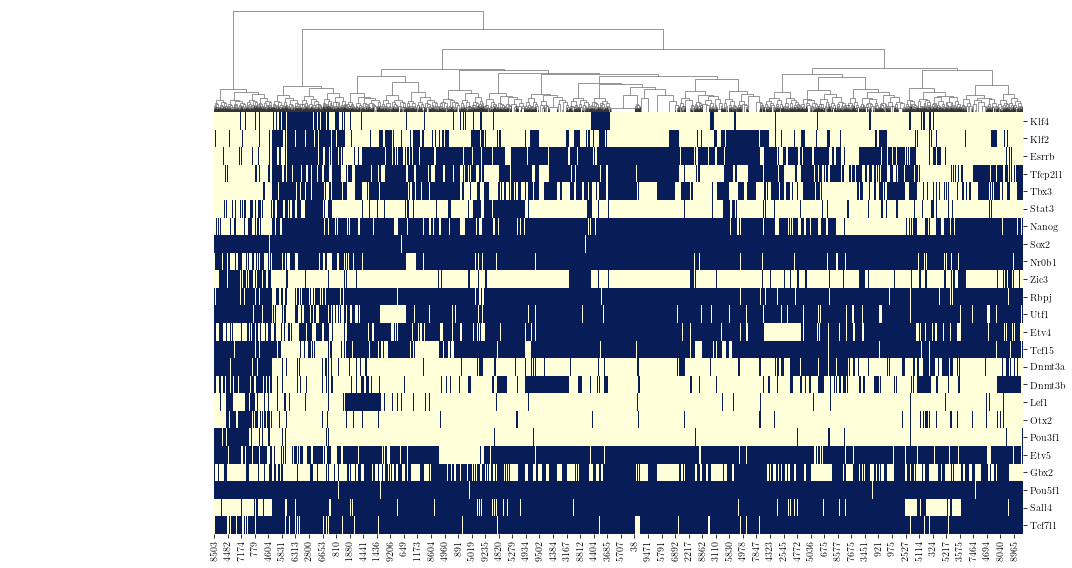

In [93]:
# Perform linkage on your numpy array
jj=10
Z = scipy.cluster.hierarchy.linkage(spins_new_lN[:,:,jj].T, method='ward')
# Note: we are showing just one simulated dataset, but you can do the same for all of them

# Plot the dendrogram and heatmap
sns.clustermap(spins_new_lN[:,:, jj], col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Clustering on Original Data

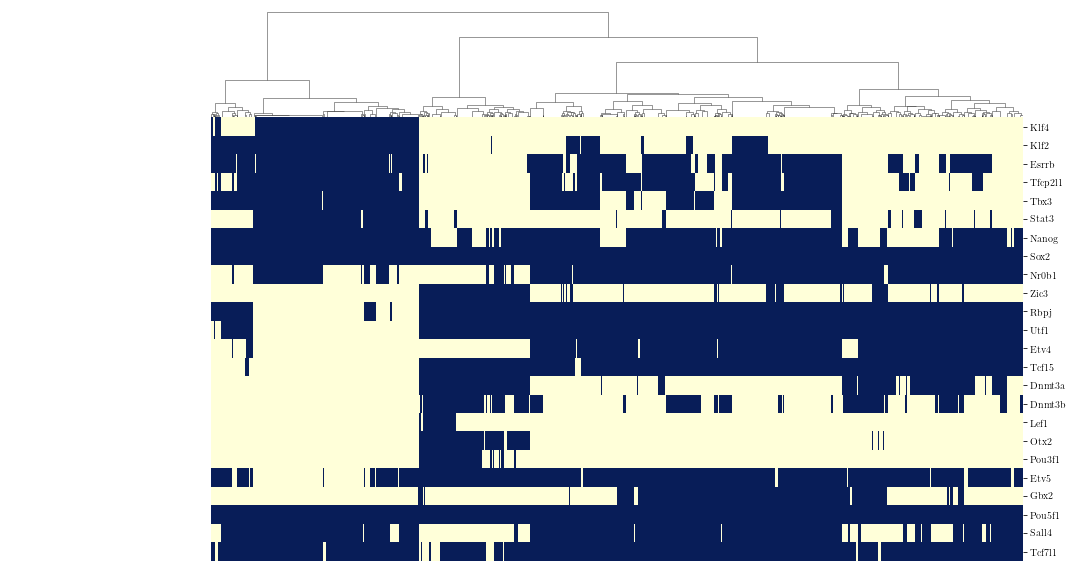

In [94]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(spins_df_lN_mb_pst.T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(spins_df_lN_mb_pst, col_linkage=Z, cmap='YlGnBu',
               yticklabels=genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

## PsiNorm

Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
0 	 0.964919 	 0.991136 	 0.5811 	 0.5767 	 -0.5353190542391589
100 	 0.162011 	 0.135921 	 0.3117 	 0.0892 	 -1.5777041946090808
200 	 0.323287 	 0.323356 	 0.204 	 0.1114 	 -1.4776633711445302
300 	 0.234006 	 0.185782 	 0.0708 	 0.027 	 -1.4487074707621825
400 	 0.163408 	 0.164035 	 0.079 	 0.0235 	 -1.4456851955098475
500 	 0.121376 	 0.122625 	 0.0516 	 0.0236 	 -1.423953858376333
600 	 0.074191 	 0.044772 	 0.045 	 0.0298 	 -1.4463964740987436
700 	 0.106101 	 0.106756 	 0.0471 	 0.0353 	 -1.4512194396870746
800 	 0.067431 	 0.044323 	 0.0398 	 0.0199 	 -1.4363900187622274


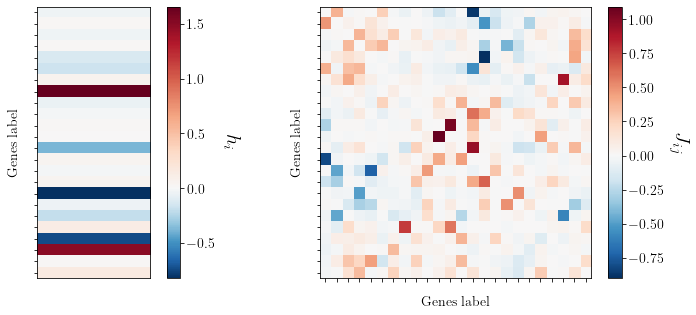


RESULTS for scRNA-seq PST MB with ISING

TP fraction: 0.67

Interaction values:
 [ 0.263  0.265 -0.049 -0.023 -0.137 -0.059  0.365  0.043  0.131  0.194
 -0.012  0.203  0.097  0.154 -0.03  -0.034  0.039 -0.037]

TP ints values:
 [ 0.263  0.265 -0.049 -0.023 -0.137 -0.     0.365  0.043  0.131  0.
 -0.012  0.     0.     0.    -0.03  -0.034  0.039 -0.   ]


In [95]:
# initialize the reconstruction
Nepochs = 900
LAMBDA = 0.03
lr = 0.6
drop = 0.99
edrop = 15

np.random.seed(1234)
model_pN_best = asynch_reconstruction(np.array(spins_df_pN_mb_pst), delta_t = 1, LAMBDA = LAMBDA, opt = 'MOMENTUM', MOM=0.95, reg = 'L1')

# reconstruct the model 
np.random.seed(1234)
model_pN_best.reconstruct(np.array(spins_df_pN_mb_pst), Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

pN_rec_tp_val, pN_rec_info_int, pN_rec_matx = funcs_general.TP_plot(TPtrial_list, model_pN_best.J, genes_order, 
                                                   inferred_int_thr=interaction_thr, Norm_Matx = False,
                                                   data_type="scRNA-seq PST MB with ISING",
                                                   figplot=False, verbose=True, nbin=30, Norm=True)



### Generating Data

(24, 8124, 100)


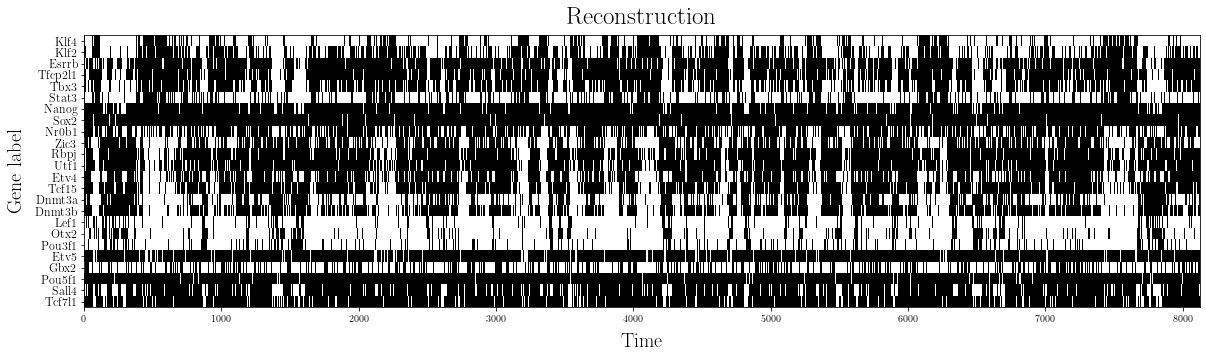

In [96]:
Ntrials=100
spins_new_pN = np.zeros((df_pN_mb_pst.shape[0], df_pN_mb_pst.shape[1], Ntrials))

for ii in range(Ntrials):
    np.random.seed(1234)
    spins_new_pN[:,:,ii] = model_pN_best.generate_samples(seed=ii*2)
    
print(spins_new_pN.shape)

fun_plotting.raster_plot(spins_new_pN[:,:,0], 'Reconstruction', 1, genes_order)
plt.show()


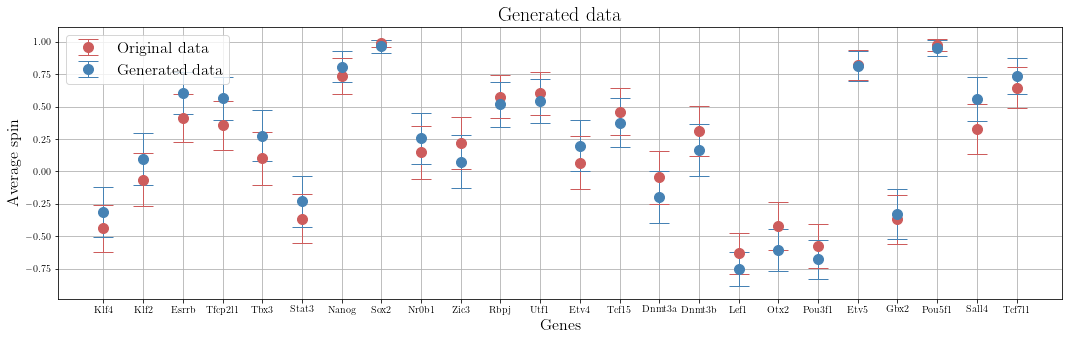

In [97]:
# plot the average activity of the genes  
fig, ax = plt.subplots(1,1, figsize=(18,5))
avg_activity_pN, avg_activity_std_pN         = funcs_ko.plot_activity(spins_df_pN_mb_pst, genes_order, "Original data", "indianred", ax)
avg_activity_pN_sim, avg_activity_std_pN_sim = funcs_ko.plot_activity_simulated(spins_new_pN, genes_order, "Generated data", "steelblue", ax)


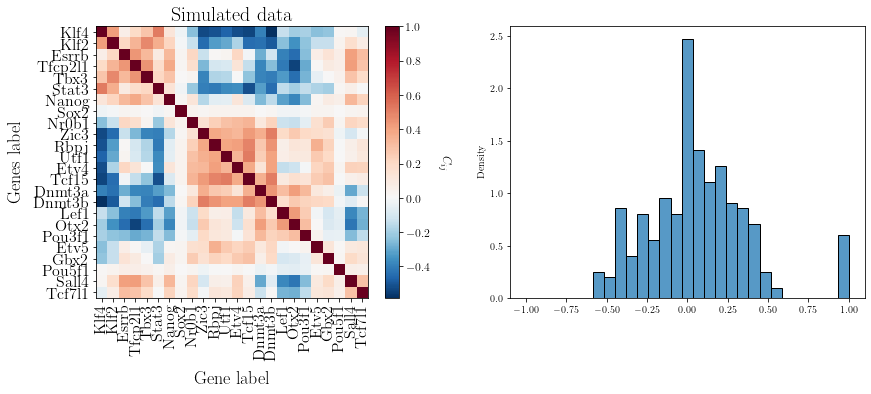

[]


In [98]:
cm_sim_pN = np.zeros((spins_new_pN.shape[0], spins_new_pN.shape[0], spins_new_pN.shape[2]))
for ii in range(spins_new_pN.shape[2]):
    cm_sim_pN[:,:, ii] = np.corrcoef(spins_new_pN[:,:,ii])
cm_sim_pN_mean = np.mean(cm_sim_pN, axis=2)

bins = np.linspace(-1, 1, 30)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim_pN_mean, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim_pN_mean), bins=bins,  ax=ax[1], stat="density")
plt.show()

# find rows and columns that contains all nan
row_nan_pN_sim = np.where(np.isnan(cm_sim_pN_mean).all(axis=1))[0]
col_nan_pN_sim = np.where(np.isnan(cm_sim_pN_mean).all(axis=0))[0]
# find union of the two arrays
idx_nan_pN_sim = np.union1d(row_nan_pN_sim, col_nan_pN_sim)
print(idx_nan_pN_sim)

In [99]:
cm_original_pN = np.corrcoef(spins_df_pN_mb_pst)

# bins = np.linspace(-1, 1, 30)
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
# figfunc.plotmat(cm_original_pN, fig, ax[0], genes_order, "Original data")
# sns.histplot(np.ndarray.flatten(cm_original_pN), bins=bins,  ax=ax[1], stat="density")
# plt.show()

# find rows and columns that contains all nan
row_nan_pN = np.where(np.isnan(cm_original_pN).all(axis=1))[0]
col_nan_pN = np.where(np.isnan(cm_original_pN).all(axis=0))[0]
# find union of the two arrays
idx_nan_pN = np.union1d(row_nan_pN, col_nan_pN)
print(idx_nan_pN)

# unify the list of indices of simulated and original matxs
idx_nan_pN = np.union1d(idx_nan_pN, idx_nan_pN_sim)


# random correlation matrix: shuffle the rows and columns of the original matrix Ntrials times
corr_matxs_rnd_pN = np.array([np.corrcoef(spins_df_pN_mb_pst_shuffle[i,:,:]) for i in range(Ntest)])
corr_matxs_rnd_pN.shape

[]


(50, 24, 24)

In [100]:
cm_orig_pN_red = cm_original_pN.copy()
cm_sim_pN_red = cm_sim_pN.copy()
corr_matx_rnd_pN_red = corr_matxs_rnd_pN.copy() 
idx_nan_pN_run = idx_nan_pN.copy()
for ii in range(len(idx_nan_pN_run)):
    print(ii, idx_nan_pN_run[ii])
    # remove the rows and columns that contains all nan
    if ii>0: # update the index of the rows and columns to be removed
        idx_nan_pN_run[ii]=idx_nan_pN_run[ii]-1
    # original data
    cm_orig_pN_red = np.delete(cm_orig_pN_red, idx_nan_pN_run[ii], axis=0)
    cm_orig_pN_red = np.delete(cm_orig_pN_red, idx_nan_pN_run[ii], axis=1)   
    #original data randomized (the shuffle is done Ntrials times)    
    corr_matx_rnd_pN_red = np.delete(corr_matx_rnd_pN_red, idx_nan_pN_run[ii], axis=1)
    corr_matx_rnd_pN_red = np.delete(corr_matx_rnd_pN_red, idx_nan_pN_run[ii], axis=2)
    # simulated data
    cm_sim_pN_red = np.delete(cm_sim_pN_red, idx_nan_pN_run[ii], axis=0)
    cm_sim_pN_red = np.delete(cm_sim_pN_red, idx_nan_pN_run[ii], axis=1)   
    
genes_selected = np.delete(genes_order, idx_nan_pN)
print("deleted: ", genes_order[idx_nan_pN])

# check if there are nans
if len(np.argwhere(np.isnan(cm_orig_pN_red))):
    print("there are nans in cm_orig_pN_red")


deleted:  []


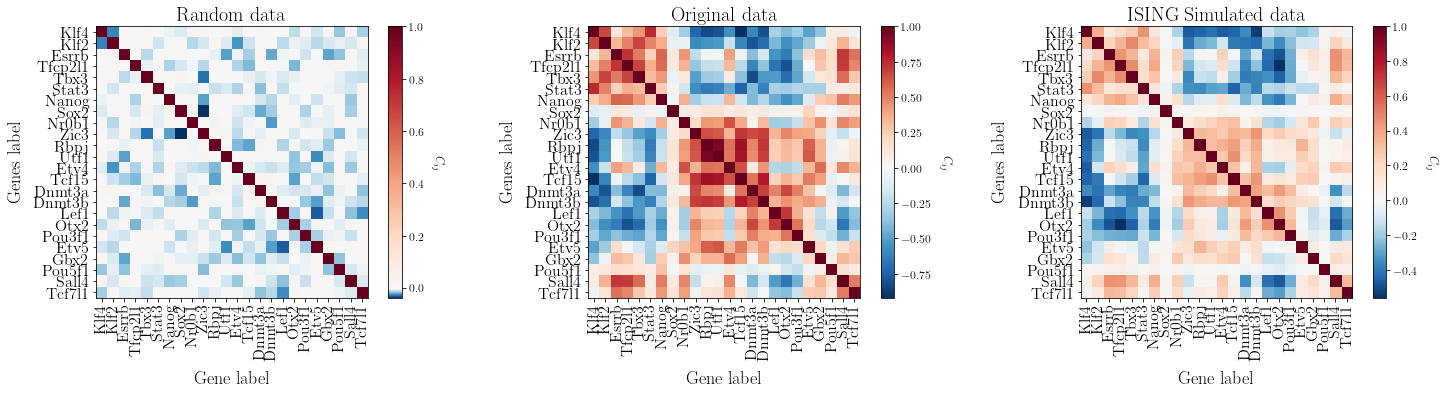

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
figfunc.plotmat(corr_matxs_rnd_pN[0,:,:], fig, ax[0], genes_order, "Random data", )
figfunc.plotmat(cm_original_pN, fig, ax[1], genes_order, "Original data")
figfunc.plotmat(cm_sim_pN[:,:,0], fig, ax[2], genes_order, "ISING Simulated data")
plt.show()



In [102]:
# compute the noise for the distance between matrixes
noise_dist = [funcs_ko.sum_squared_abs_diff(cm_orig_pN_red, corr_matx_rnd_pN_red[i,:,:]) for i in range(Ntest)]
noise_dist = np.mean(noise_dist)
# print(noise_dist)

# compute the  weighted distance between the original and simulated matrixes
result_IO = [funcs_ko.sum_squared_abs_diff(cm_orig_pN_red, cm_sim_pN_red[:,:,i]) for i in range(Ntrials)]
result_IO = np.mean(result_IO)/ noise_dist
print(result_IO)       


0.4215830773742138


### Clustering on Simulated Data

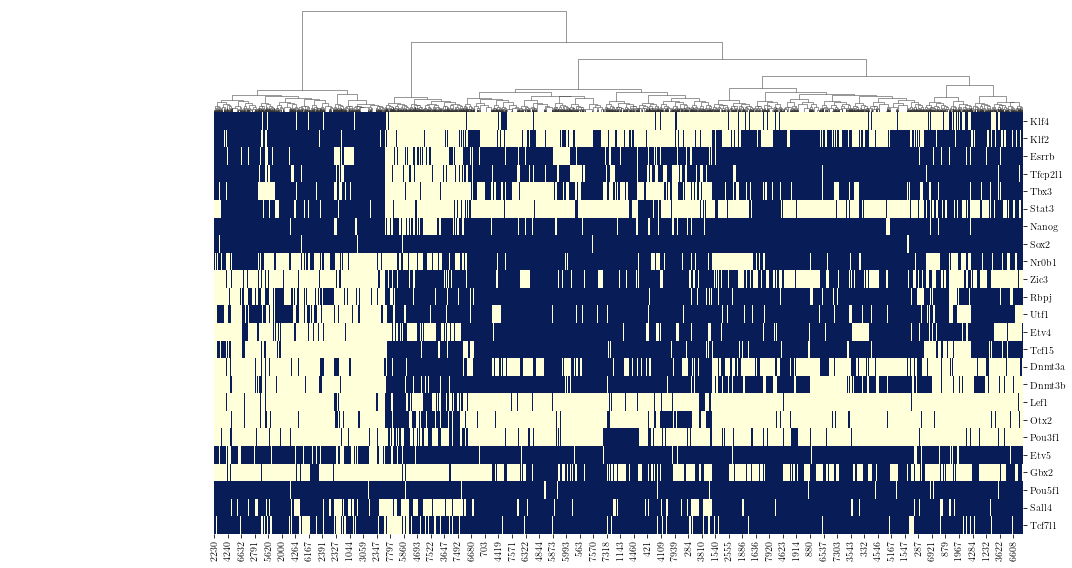

In [103]:
# Perform linkage on your numpy array
jj=10
Z = scipy.cluster.hierarchy.linkage(spins_new_pN[:,:,jj].T, method='ward')
# Note: we are showing just one simulated dataset, but you can do the same for all of them

# Plot the dendrogram and heatmap
sns.clustermap(spins_new_pN[:,:, jj], col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Clustering on Original Data

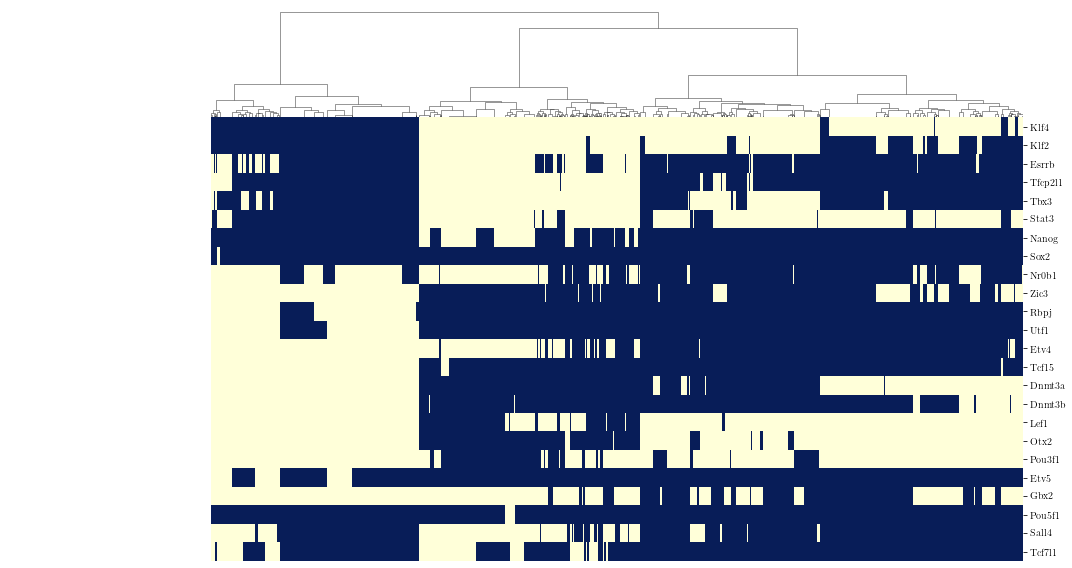

In [104]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(spins_df_pN_mb_pst.T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(spins_df_pN_mb_pst, col_linkage=Z, cmap='YlGnBu',
               yticklabels=genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

# Knock Out

In [105]:
N_test_KO = 100
thr_KO_Leeb = 0
thr_KO = thr_KO_Leeb

### Leeb data

In [106]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)
df_KO_N24_Leeb_cl.head(2)

,Rbpj,Etv5,Tcf7l1
Klf4,2.890194,2.386695,0.00000
Klf2,0.000000,0.000000,2.33868


## PsiNorm

### KO Rbpj

Fraction of agreement:  1.0
# of data Considered:  7.0


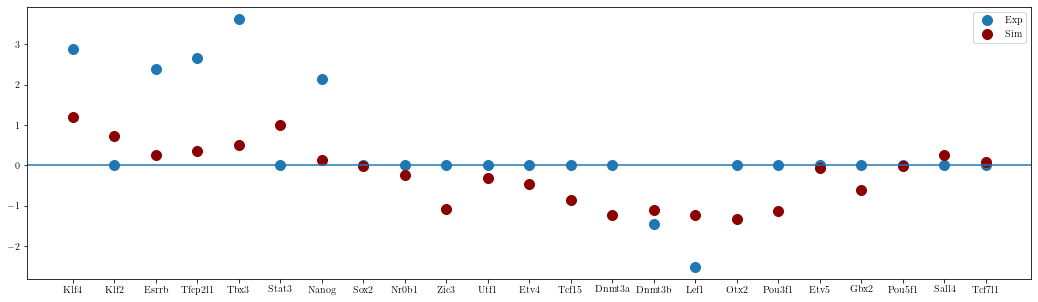

In [107]:
# KO info
KO_gene = "Rbpj"
KO_pN_rec_matx, KO_pN_rec_field, KO_gene_idk, KO_genes_order = funcs_ko.info_KO(pN_high_meanMatx, model_pN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_R = funcs_ko.KO_logFC_sim(KO_pN_rec_matx, KO_pN_rec_field, genes_order, 
                         wt_pN_mb_pst_avg_spin, model_pN_best,  N_test_KO=N_test_KO)         # logFC Simulated (takes time)

funcs_ko.KO_plotLogFC_ExpAndSim(logFC_Leeb_R, logFC_Sim_R, KO_genes_order)


# Fraction of LogFC in Agreement
mean_in_agreement_R, data_considered_R = funcs_ko.KO_comparison_ExpVsSim(logFC_Leeb_R, logFC_Sim_R, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_R)
print("# of data Considered: ",data_considered_R.mean())


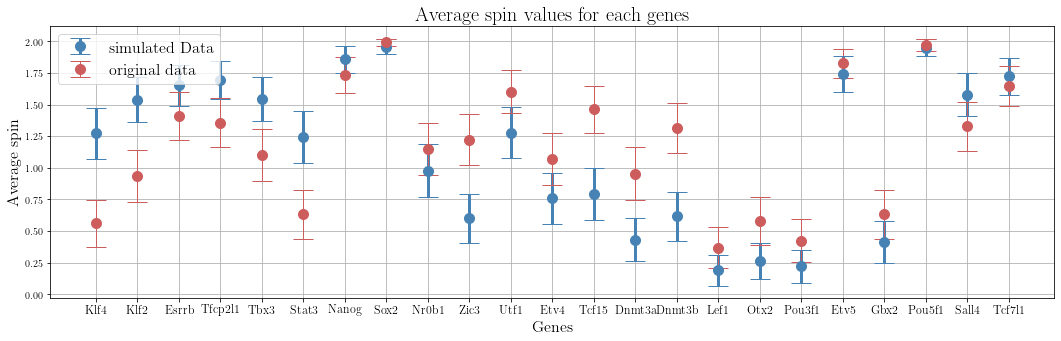

In [108]:
funcs_ko.KO_plots_oneSim(model_pN_best, KO_pN_rec_matx, KO_pN_rec_field, KO_genes_order,
                wt_pN_mb_pst_avg_spin, wt_pN_mb_pst_std_spin,
                raster=False, avg=True)

### KO Etv5

Fraction of agreement:  0.9797619047619048
# of data Considered:  6.98


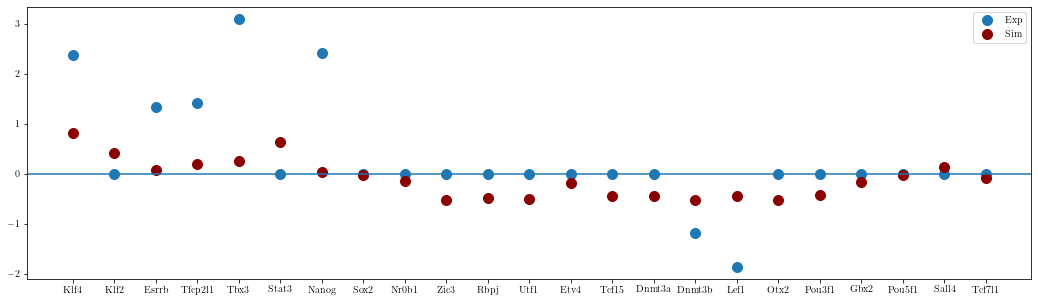

In [109]:
# KO info
KO_gene = "Etv5"
KO_pN_rec_matx, KO_pN_rec_field, KO_gene_idk, KO_genes_order = funcs_ko.info_KO(pN_high_meanMatx, model_pN_best,KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_R = funcs_ko.KO_logFC_sim(KO_pN_rec_matx, KO_pN_rec_field, genes_order, 
                         wt_pN_mb_pst_avg_spin, model_pN_best,  N_test_KO=N_test_KO)         # logFC Simulated (takes time)

funcs_ko.KO_plotLogFC_ExpAndSim(logFC_Leeb_R, logFC_Sim_R, KO_genes_order)


# Fraction of LogFC in Agreement
mean_in_agreement_R, data_considered_R = funcs_ko.KO_comparison_ExpVsSim(logFC_Leeb_R, logFC_Sim_R, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_R)
print("# of data Considered: ",data_considered_R.mean())


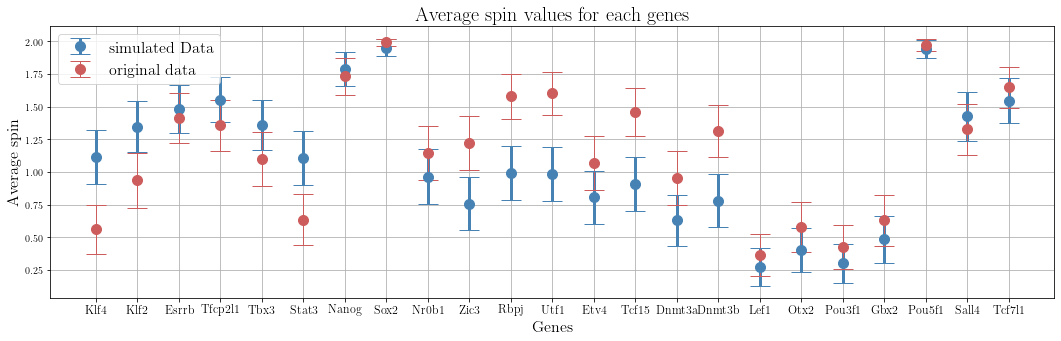

In [110]:
funcs_ko.KO_plots_oneSim(model_pN_best,KO_pN_rec_matx, KO_pN_rec_field, KO_genes_order,
                wt_pN_mb_pst_avg_spin, wt_pN_mb_pst_std_spin,
                raster=False, avg=True)

### KO Tcf7l1

Fraction of agreement:  0.2506666666666667
# of data Considered:  5.99


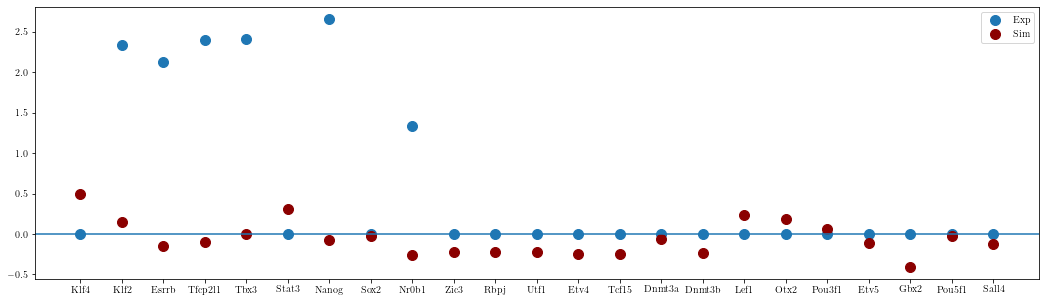

In [111]:
# KO info
KO_gene = "Tcf7l1"
KO_pN_rec_matx, KO_pN_rec_field, KO_gene_idk, KO_genes_order = funcs_ko.info_KO(pN_high_meanMatx, model_pN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_T = funcs_ko.KO_logFC_sim(KO_pN_rec_matx, KO_pN_rec_field, genes_order, 
                         wt_pN_mb_pst_avg_spin, model_pN_best, N_test_KO=N_test_KO)         # logFC Simulated (takes time)

funcs_ko.KO_plotLogFC_ExpAndSim(logFC_Leeb_T, logFC_Sim_T, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_T, data_considered_T = funcs_ko.KO_comparison_ExpVsSim(logFC_Leeb_T, logFC_Sim_T, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_T)
print("# of data Considered: ",data_considered_T.mean())

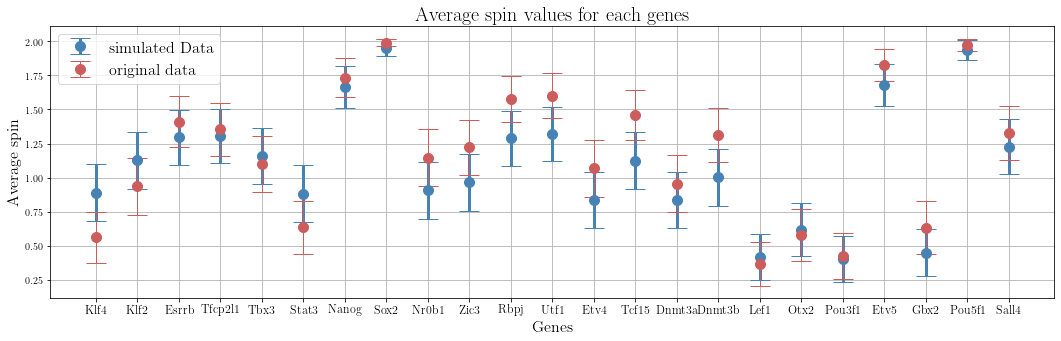

In [112]:
funcs_ko.KO_plots_oneSim(model_pN_best,KO_pN_rec_matx, KO_pN_rec_field, KO_genes_order,
                wt_pN_mb_pst_avg_spin, wt_pN_mb_pst_std_spin,
                raster=False, avg=True)

### KO of three genes

In [221]:
KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

KO_pN_rec_matx_T_spins, KO_pN_rec_field_T_spins, KO_gene_idk_T, KO_genes_order_T = funcs_ko.info_KO(pN_high_meanMatx, model_pN_best, KO_gene_T_spins,
                                                                               genes_order=genes_order, multiple=True)

# average activity for wt
wt_T_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk_T)+1
wt_T_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk_T)

KO_T_spins, KO_T_avg_spin, KO_T_std_spin = funcs_ko.KO_activity_sim(KO_pN_rec_matx_T_spins, KO_pN_rec_field_T_spins, KO_genes_order_T, model_pN_best, N_test_KO=100, n_time=8124)
print(KO_T_spins.shape)


(21, 8124, 100)


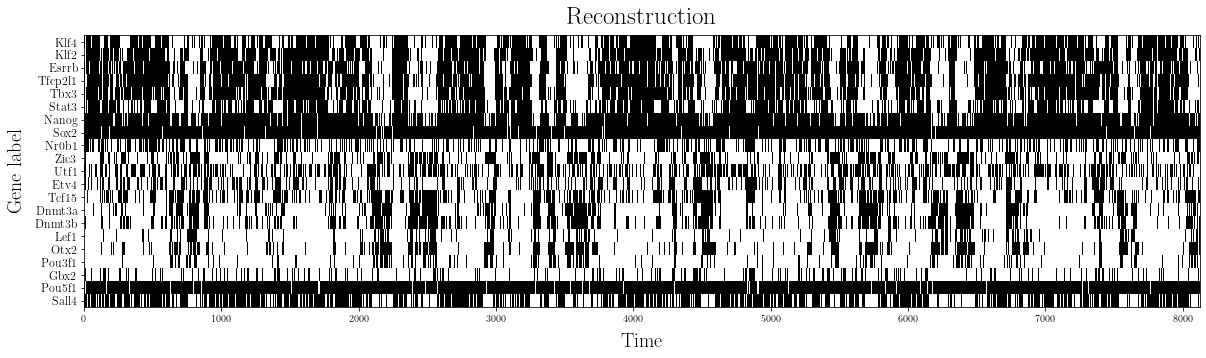

In [222]:
fun_plotting.raster_plot(KO_T_spins[:,:,1], 'Reconstruction', 1, KO_genes_order_T)
plt.show()

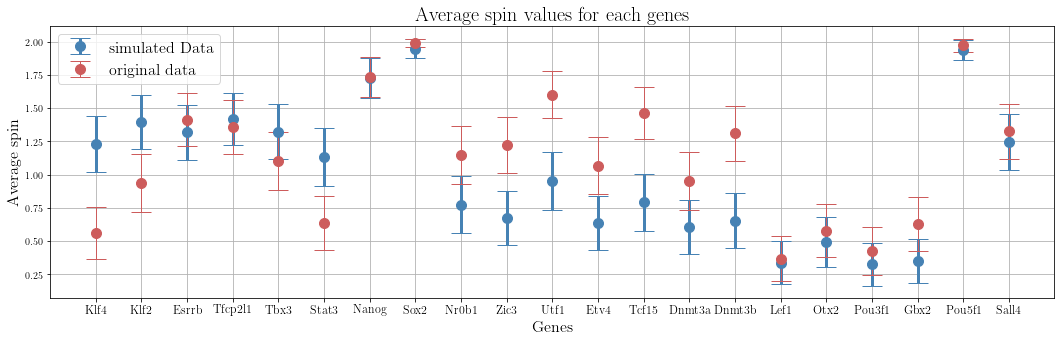

In [223]:
funcs_ko.KO_plots_SimMultiple(KO_T_spins, KO_genes_order_T, wt_T_pN_mb_pst_avg_spin, wt_T_pN_mb_pst_std_spin)

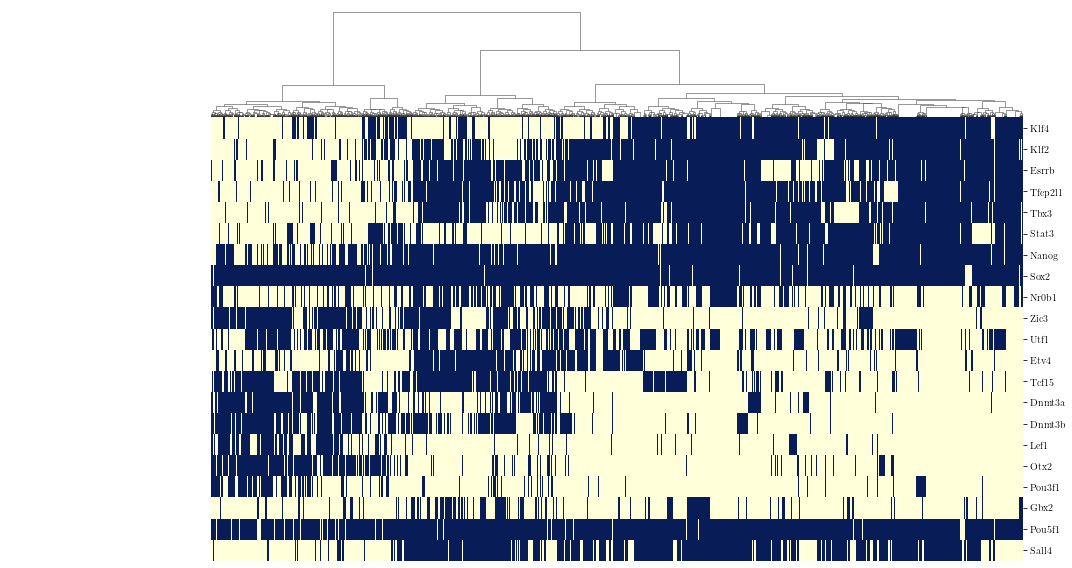

In [224]:
# # Perform linkage on your numpy array
# Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,1].T, method='ward')

# # Plot the dendrogram and heatmap
# sns.clustermap(KO_T_spins[:,:,1], col_linkage=Z, cmap='YlGnBu',
#                yticklabels=KO_genes_order, xticklabels=[],
#                cbar=False, figsize=(15,8), row_cluster=False )

# plt.xticks([])
# plt.yticks([])

# plt.show()

## LogNorm

### KO Rbpj

Fraction of agreement:  0.5885714285714284
# of data Considered:  7.0


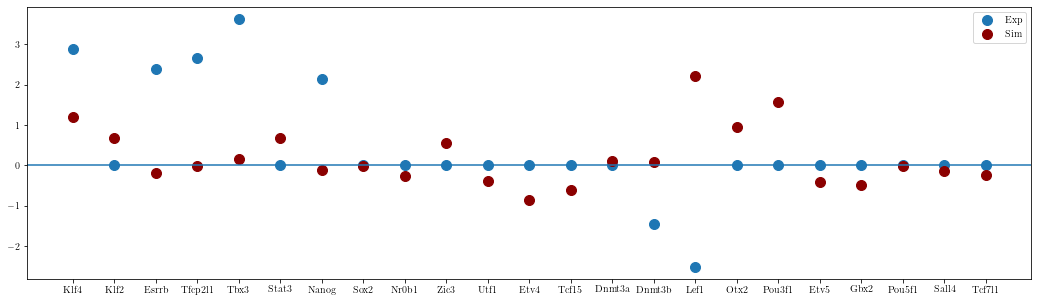

In [113]:
# KO info
KO_gene = "Rbpj"
KO_lN_rec_matx, KO_lN_rec_field, KO_gene_idk, KO_genes_order = funcs_ko.info_KO(lN_high_meanMatx, model_lN_best,KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_R = funcs_ko.KO_logFC_sim(KO_lN_rec_matx, KO_lN_rec_field, genes_order, 
                         wt_lN_mb_pst_avg_spin,model_lN_best,  N_test_KO=N_test_KO)         # logFC Simulated (takes time)

funcs_ko.KO_plotLogFC_ExpAndSim(logFC_Leeb_R, logFC_Sim_R, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_R, data_considered_R = funcs_ko.KO_comparison_ExpVsSim(logFC_Leeb_R, logFC_Sim_R, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_R)
print("# of data Considered: ",data_considered_R.mean())

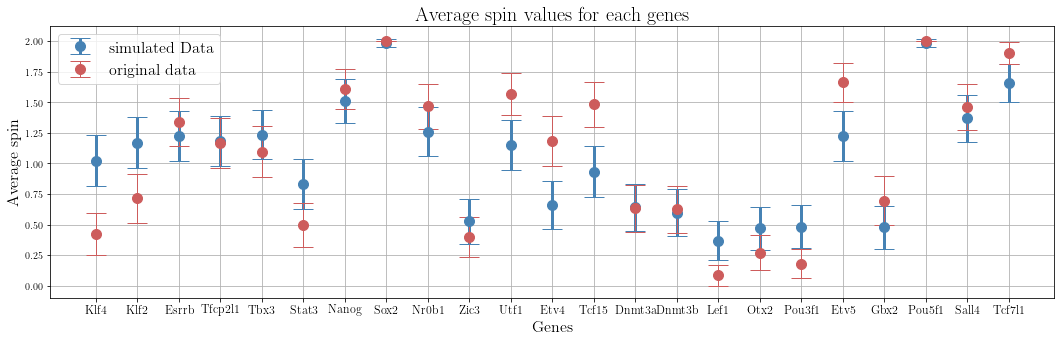

In [114]:
funcs_ko.KO_plots_oneSim(model_lN_best,KO_lN_rec_matx, KO_lN_rec_field, KO_genes_order,
                wt_lN_mb_pst_avg_spin, wt_lN_mb_pst_std_spin,
                raster=False, avg=True)

### KO Etv5

Fraction of agreement:  0.8485714285714286
# of data Considered:  7.0


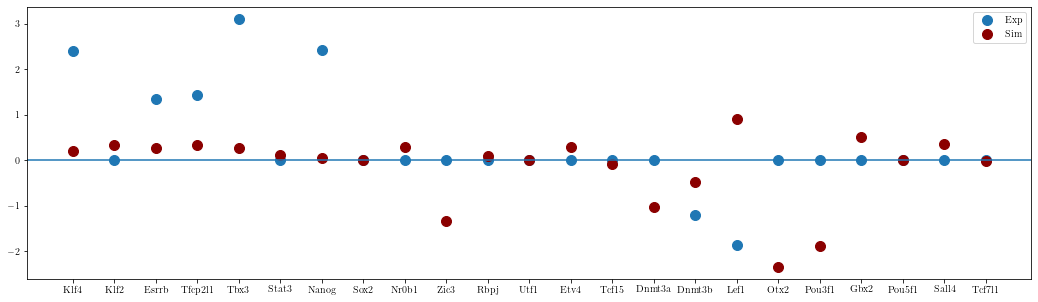

In [115]:
KO_gene = "Etv5"
KO_lN_rec_matx, KO_lN_rec_field, KO_gene_idk, KO_genes_order = funcs_ko.info_KO(lN_high_meanMatx, model_lN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_E = funcs_ko.KO_logFC_sim(KO_lN_rec_matx, KO_lN_rec_field, genes_order, 
                         wt_lN_mb_pst_avg_spin,model_lN_best, N_test_KO=N_test_KO)         # logFC Simulated (takes time)

funcs_ko.KO_plotLogFC_ExpAndSim(logFC_Leeb_E, logFC_Sim_E, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_E, data_considered_E = funcs_ko.KO_comparison_ExpVsSim(logFC_Leeb_E, logFC_Sim_E, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_E)
print("# of data Considered: ",data_considered_E.mean())


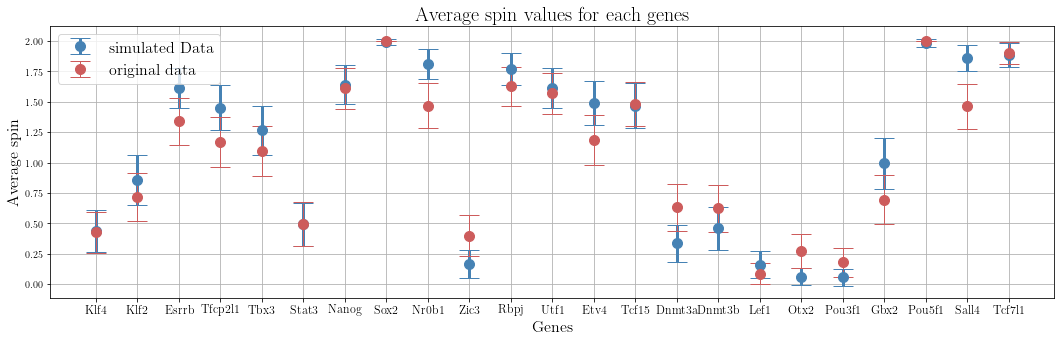

In [116]:
funcs_ko.KO_plots_oneSim(model_lN_best,KO_lN_rec_matx, KO_lN_rec_field, KO_genes_order,
                wt_lN_mb_pst_avg_spin, wt_lN_mb_pst_std_spin,
                raster=False, avg=True)

### KO Tcf7l1

Fraction of agreement:  0.0
# of data Considered:  6.0


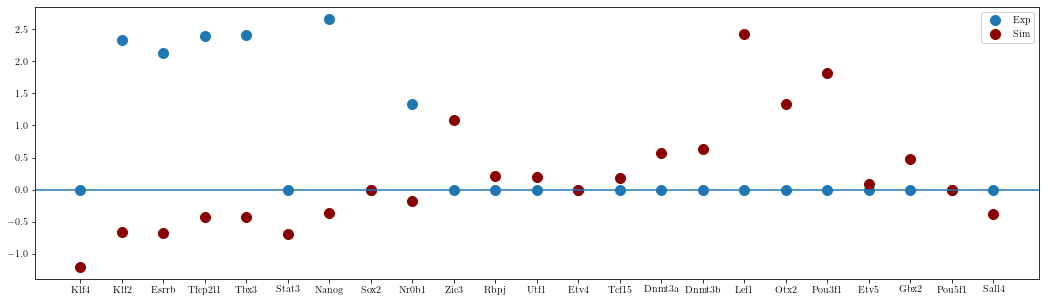

In [117]:
KO_gene = "Tcf7l1"

KO_lN_rec_matx, KO_lN_rec_field, KO_gene_idk, KO_genes_order = funcs_ko.info_KO(lN_high_meanMatx, model_lN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_T = funcs_ko.KO_logFC_sim(KO_lN_rec_matx, KO_lN_rec_field, genes_order, 
                         wt_lN_mb_pst_avg_spin, model_lN_best, N_test_KO=N_test_KO)         # logFC Simulated (takes time)

funcs_ko.KO_plotLogFC_ExpAndSim(logFC_Leeb_T, logFC_Sim_T, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_T, data_considered_T = funcs_ko.KO_comparison_ExpVsSim(logFC_Leeb_T, logFC_Sim_T, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_T)
print("# of data Considered: ",data_considered_T.mean())




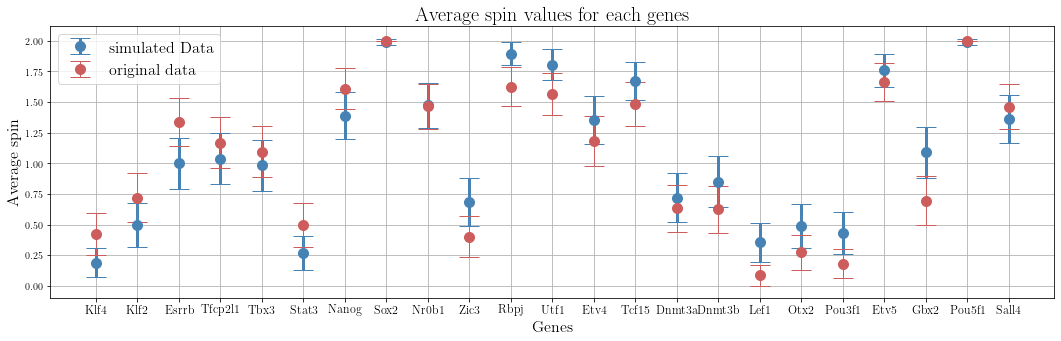

In [119]:
funcs_ko.KO_plots_oneSim(model_lN_best,KO_lN_rec_matx, KO_lN_rec_field, KO_genes_order,
                wt_lN_mb_pst_avg_spin, wt_lN_mb_pst_std_spin,
                raster=False, avg=True)

### KO of three genes

In [213]:
KO_gene_T_spins = ["Rbpj", "Etv5", "Tcf7l1"]

KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_gene_idk_T, KO_genes_order_T = funcs_ko.info_KO(lN_high_meanMatx, model_lN_best, KO_gene_T_spins,
                                                                               genes_order=genes_order, multiple=True)

# average activity for wt
wt_T_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk_T)+1

wt_T_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk_T)


KO_T_spins, KO_T_avg_spin, KO_T_std_spin = funcs_ko.KO_activity_sim(KO_lN_rec_matx_T_spins, KO_lN_rec_field_T_spins, KO_genes_order_T, model_lN_best, N_test_KO=100)
print(KO_T_spins.shape)




(21, 9547, 100)


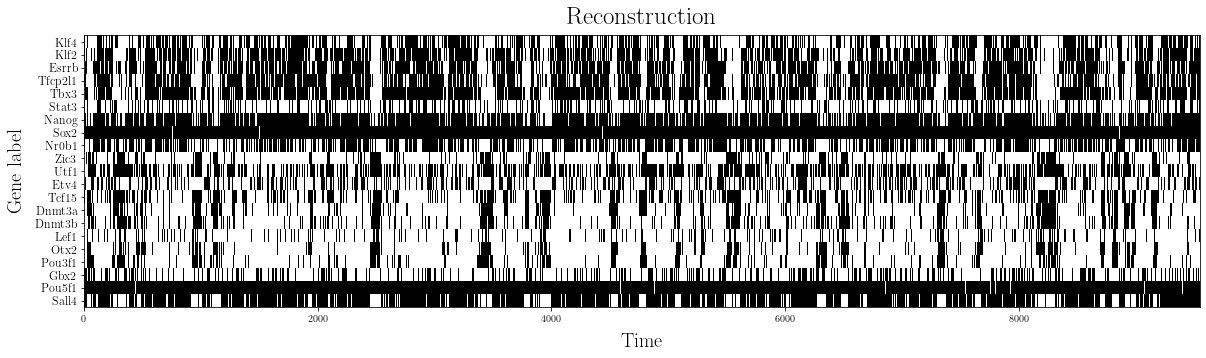

In [214]:
fun_plotting.raster_plot(KO_T_spins[:,:,1], 'Reconstruction', 1, KO_genes_order_T)
plt.show()

(21, 100) (21, 100)


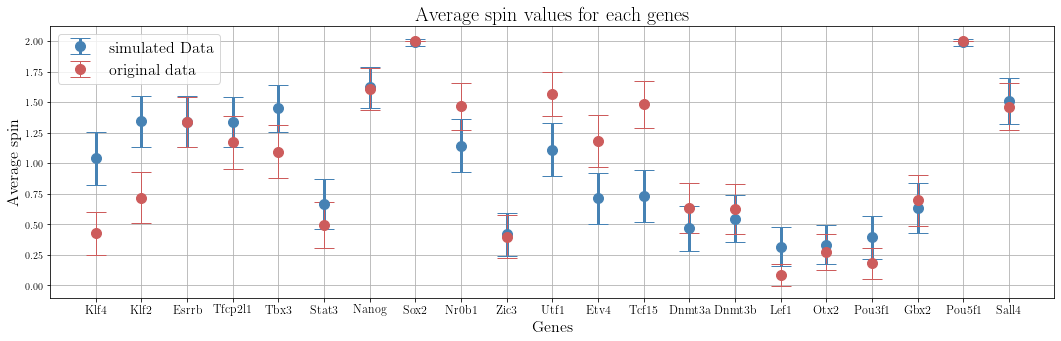

In [219]:
funcs_ko.KO_plots_SimMultiple(KO_T_spins, KO_genes_order_T, wt_T_lN_mb_pst_avg_spin, wt_T_lN_mb_pst_std_spin)

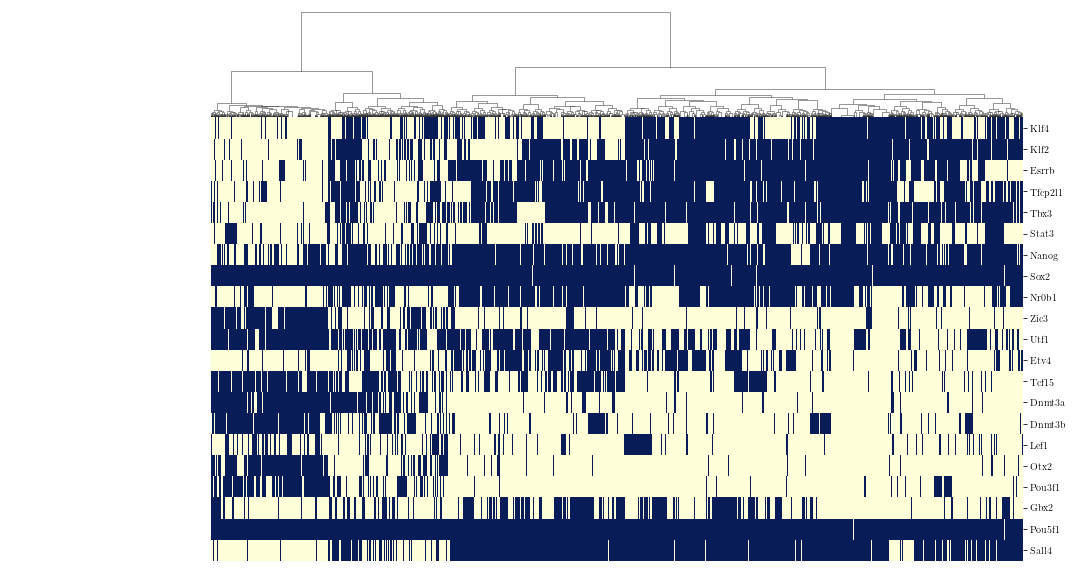

In [197]:
# Perform linkage on your numpy array
Z = scipy.cluster.hierarchy.linkage(KO_T_spins[:,:,1].T, method='ward')

# Plot the dendrogram and heatmap
sns.clustermap(KO_T_spins[:,:,1], col_linkage=Z, cmap='YlGnBu',
               yticklabels=KO_genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()

# Network Analysis: LogNorm

Adjacency matrix

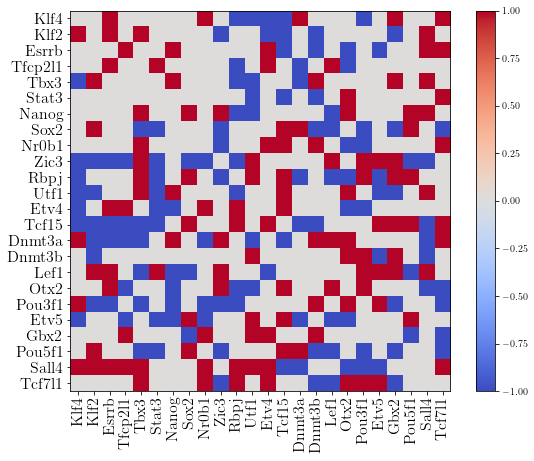

%1s : 0.22
%-1s : 0.23
%0s : 0.55


In [26]:
adj_matx = na.to_adj_matrix(lN_high_meanMatx, thr = 0.1)
na.adj_plot(adj_matx)

print("%1s :", f"{len(np.where(adj_matx==1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")
print("%-1s :", f"{len(np.where(adj_matx==-1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

print("%0s :", f"{len(np.where(adj_matx==0)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

Network reciprocity 0.5


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/NetAnalysis.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genes_list, rotation=45, fontsize=16)


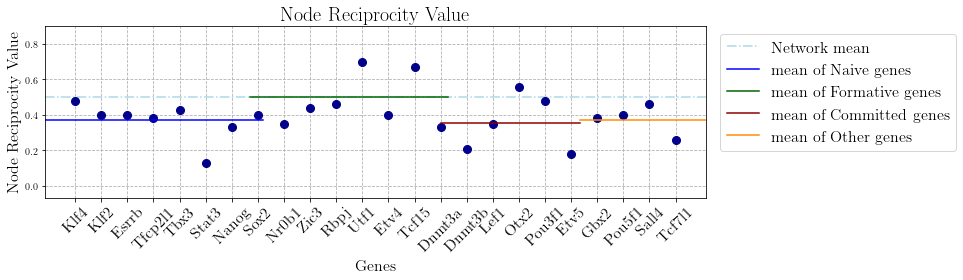

Naive 0.37 +\_ 0.10
Formative 0.50 +\_ 0.13
Committed 0.35 +\_ 0.14
Others 0.38 +\_ 0.07


In [27]:
# Reciprocity
reciprocity_value = na.reciprocity(adj_matx)
print("Network reciprocity", reciprocity_value)

nodes_rec, mean_TypeGenes, std_TypeGenes = na.nodes_reciprocity(adj_matx, net_reciprocity = reciprocity_value, genes_list=genes_order)

print("Naive", "{:.2f}".format(mean_TypeGenes[0]), "+\_", "{:.2f}".format(std_TypeGenes[0]))
print("Formative", "{:.2f}".format(mean_TypeGenes[1]), "+\_", "{:.2f}".format(std_TypeGenes[1]))
print("Committed", "{:.2f}".format(mean_TypeGenes[2]), "+\_", "{:.2f}".format(std_TypeGenes[2]))
print("Others", "{:.2f}".format(mean_TypeGenes[3]), "+\_", "{:.2f}".format( std_TypeGenes[3]))


Degree

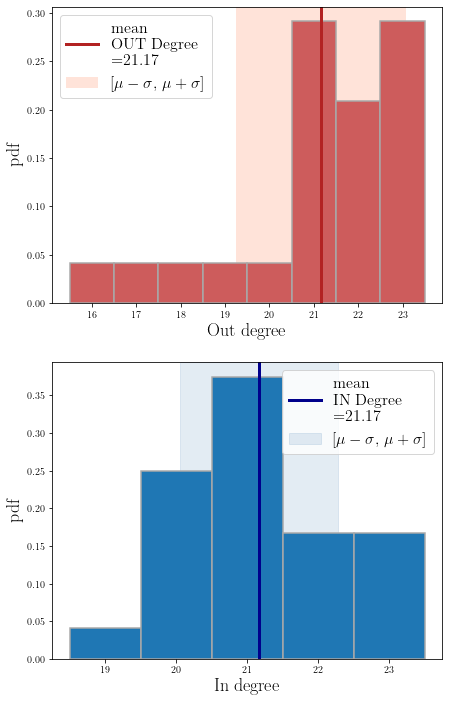

In [66]:
na.plot_degree_distribution(adj_matx)

23.0 23.0


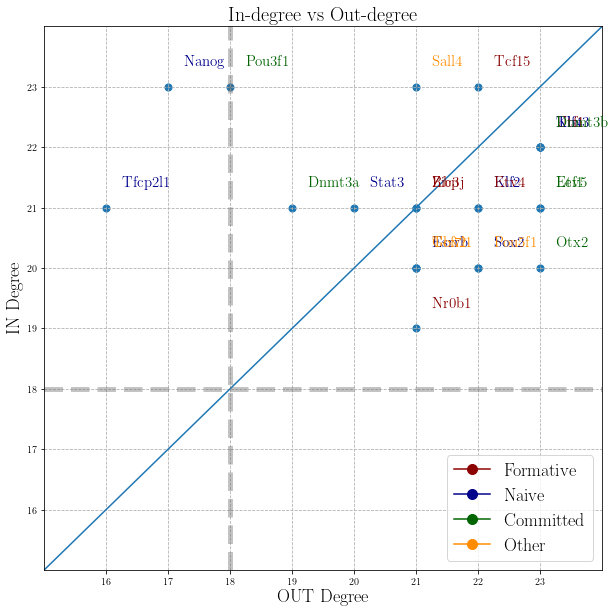

0.02


In [67]:
outdegree, indegree, Sp_corr = na.plot_indegree_outdegree(adj_matx)
print(f"{Sp_corr:.2f}")

## INTERACTION DISTRIBUTION

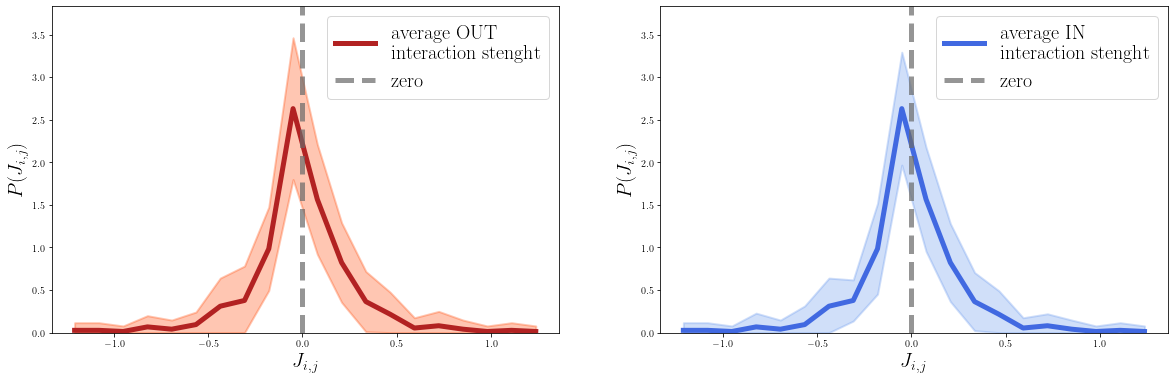

In [68]:
na.plot_histograms(lN_high_meanMatx)


### Hubs

OUT hubs:
 ['Klf4' 'Tbx3' 'Utf1' 'Dnmt3b' 'Lef1']
IN hubs:
 ['Nanog' 'Tcf15' 'Pou3f1' 'Sall4' 'Klf4']
OUT hubs


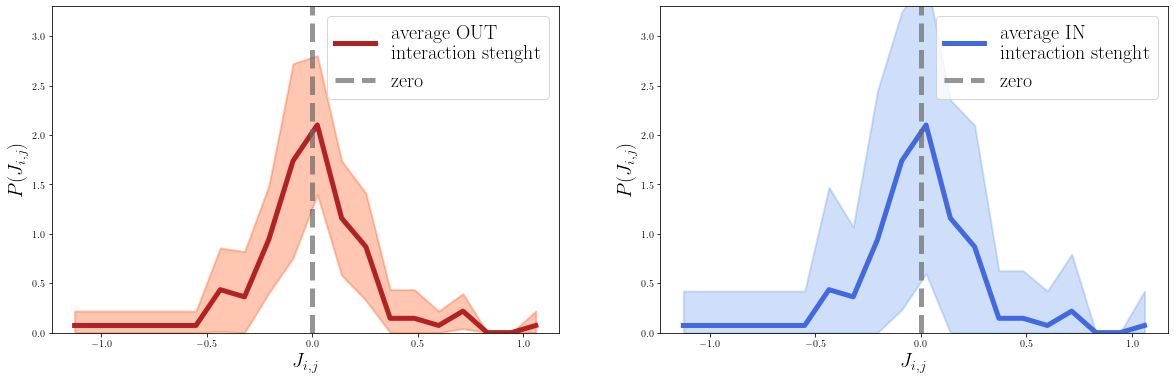

IN hubs


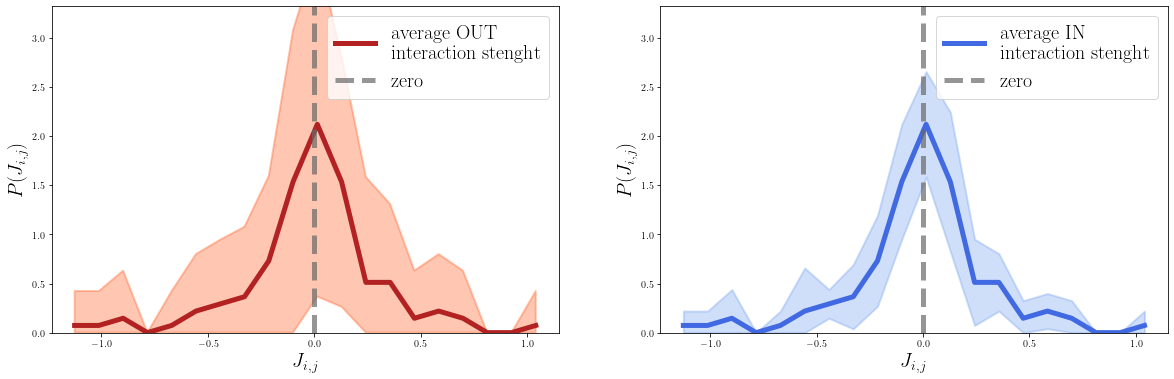

In [69]:
n_hubs = 5
print("OUT hubs:\n", na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])
print("IN hubs:\n", na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])

print("OUT hubs")
out_hubs_idxs = na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(lN_high_meanMatx[:,out_hubs_idxs.astype("int")])

print("IN hubs")
in_hubs_idxs = na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(lN_high_meanMatx[in_hubs_idxs.astype("int"), :])


## NETWORK

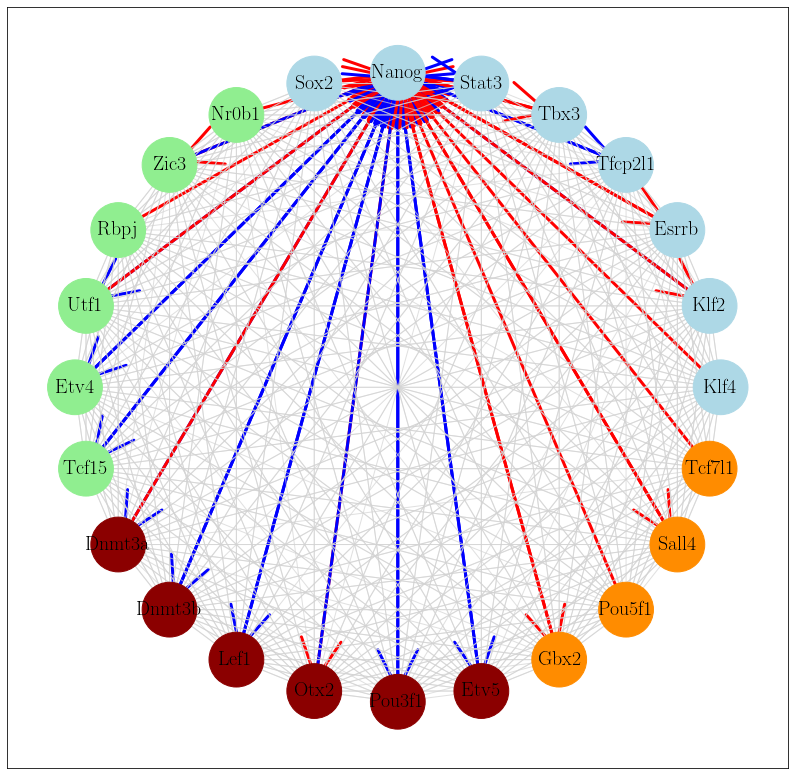

In [70]:
na.visualize_graph_selNode(adj_matx, genes_order, naive, formative, committed, "Nanog")



In [71]:
interactions = na.string_list_to_tuple(TPtrial_list)
correlations_known = na.string_list_to_tuple(Interactions_list)

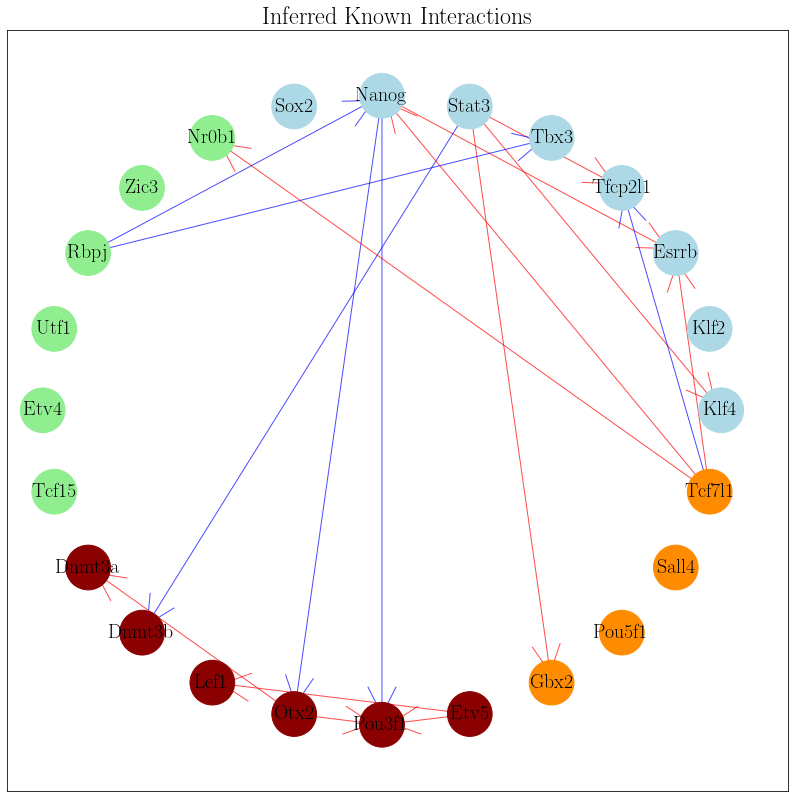

In [72]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  interactions, "Inferred Known Interactions")
# 

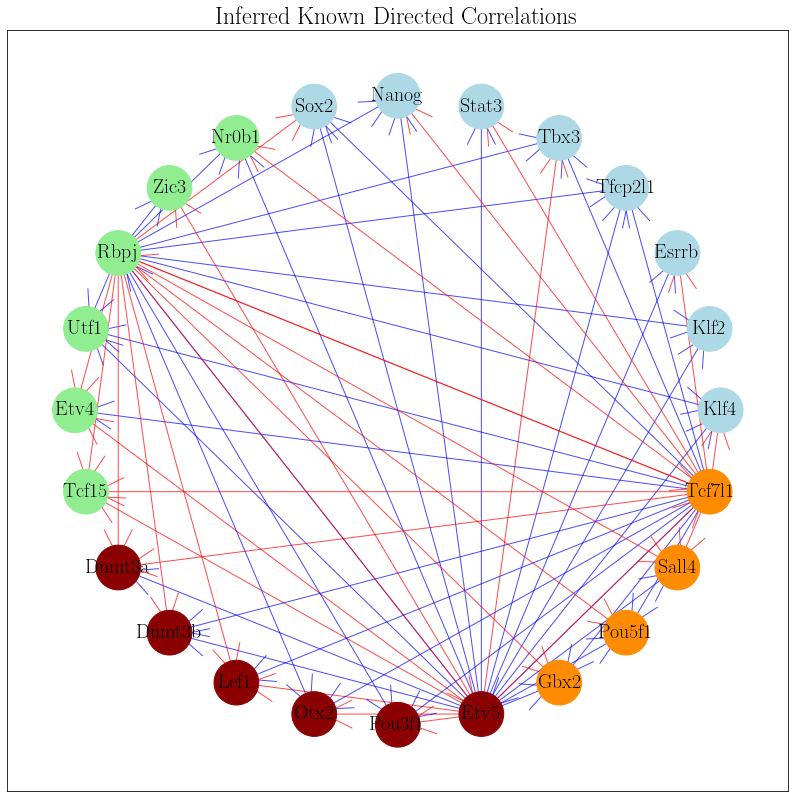

In [73]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  correlations_known, "Inferred Known Directed Correlations")
